In [1]:
import torch
import torchvision

print( torch.__version__)
print( torchvision.__version__)

2.2.2+cu121
0.17.2+cu121


In [2]:
import matplotlib.pyplot as plt
from torchinfo import summary
from modules import data_setup, engine

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## 1. Download Data

In [4]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path( "data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
	print( f"{ image_path} directory exists, skipping downloading...")
else:
	print( f"Did not find { image_path}, downloading it...")
	image_path.mkdir( parents=True, exist_ok=True)

	with open( data_path / "pizza_steak_sushi.zip", "wb") as f:
		request = requests.get( "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
		print( "Downloading pizza, steak, sushi data...")
		f.write( request.content)

	with zipfile.ZipFile( data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
		print( "Unzipping pizza, steak, sushi data...")
		zip_ref.extractall( image_path)

	os.remove( data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists, skipping downloading...


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transform for `torchvision.models` (manual creation)

In [6]:
from torchvision import transforms

normalize = transforms.Normalize( mean=[ 0.485, 0.456, 0.406],
								  std=[ 0.229, 0.224, 0.225])

manual_transforms = transforms.Compose( [
	transforms.Resize( ( 224, 224)),
	transforms.ToTensor(),
	normalize
])

In [7]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders( train_dir=train_dir,
																   				test_dir=test_dir,
																   				transform=manual_transforms,
																				batch_size=32,
																				num_workers=1)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1cf7906e5d0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

In [8]:
weigths = torchvision.models.EfficientNet_B0_Weights.DEFAULT

weigths

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weigths.transforms()

auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders( train_dir=train_dir,
																   				test_dir=test_dir,
																   				transform=auto_transforms,
																				batch_size=32,
																				num_workers=1)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1cf79083010>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

### 3.1 Setting up a pretrained model

In [11]:
# Old method (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0( pretrained=True)

# New method (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0( weights=weights).to( device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.2 Getting a summary of our model

In [13]:
from torchinfo import summary

summary( model=model,
		 input_size=[ 1, 3, 224, 224],
		 col_names=[ "input_size", "output_size", "num_params", "trainable"],
		 row_settings=[ "var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         864                       True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         64                        True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --                

### 3.3 Freezing the base model and changing the output layer

In [14]:
# Freeze all of the base layers in EFFNetB0
for param in model.features.parameters():
	param.requires_grad = False

In [15]:
# Update the classifier head

torch.manual_seed( 42)
torch.cuda.manual_seed( 42)

model.classifier = torch.nn.Sequential(
	torch.nn.Dropout( p=0.2, inplace=True),
	torch.nn.Linear( in_features=1280, out_features=len( class_names), bias=True)
).to( device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [16]:
summary( model=model,
		 input_size=[ 1, 3, 224, 224],
		 col_names=[ "input_size", "output_size", "num_params", "trainable"],
		 row_settings=[ "var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential (features)                                      [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         [1, 32, 112, 112]         --         

## 4. Train Model

In [17]:
# define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( params=model.parameters(), lr=0.001)

In [18]:
from modules import engine

torch.manual_seed( 42)
torch.cuda.manual_seed( 42)

from timeit import default_timer as timer

start_time = timer()

results = engine.train( model,
					    train_dataloader,
						test_dataloader,
						optimizer,
						loss_fn,
						epochs=5,
						device=device)

end_time = timer()

print( f"[INFO] Total training time: { end_time - start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0947 | train_acc: 0.4023 | test_loss: 0.9138 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8706 | train_acc: 0.7891 | test_loss: 0.7913 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.7712 | train_acc: 0.7852 | test_loss: 0.7447 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7126 | train_acc: 0.7617 | test_loss: 0.6392 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6221 | train_acc: 0.7891 | test_loss: 0.6278 | test_acc: 0.8561
[INFO] Total training time: 70.793 seconds


## 5. Evaluate model by plotting loss curves

In [19]:
try:
	from modules.helper_functions import plot_loss_curves
except:
	print( f"[INFO] Couldn't find helper_functions.py")

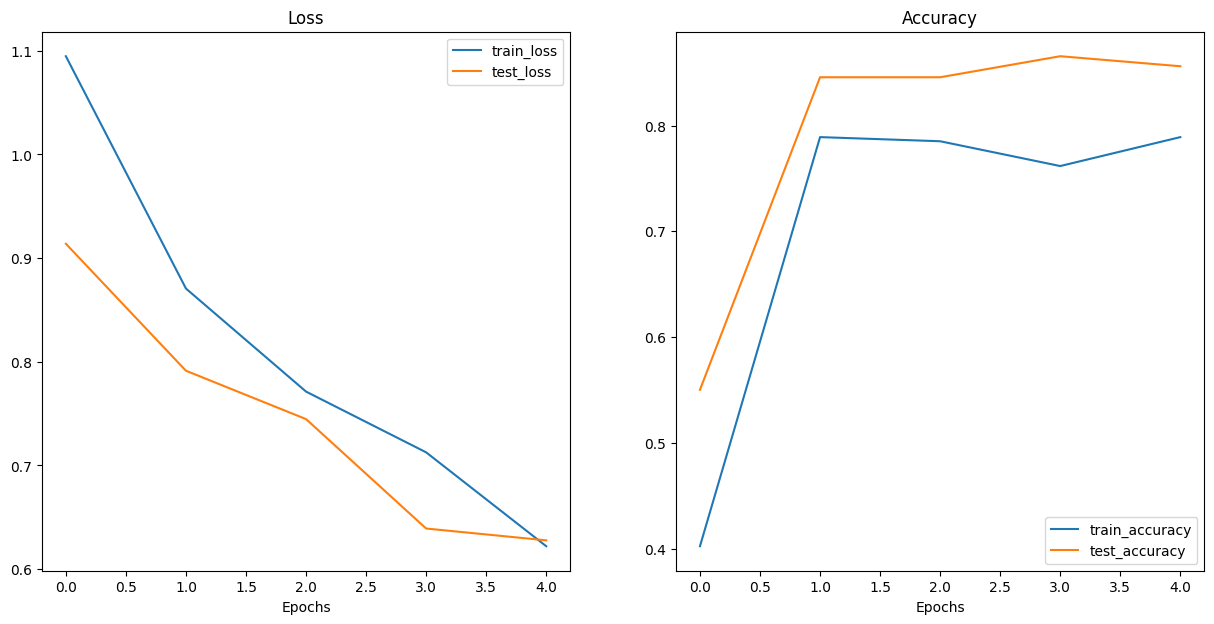

In [20]:
plot_loss_curves( results)

## 6. Make prediction on images from the test set

In [21]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_image( model: torch.nn.Module,
						 iamge_path: str,
						 class_names: List[ str],
						 image_size: Tuple[ int, int] = ( 224, 224),
						 transform: torchvision.transforms = None,
						 device: torch.device = device):
	
	img = Image.open( image_path)

	if transform is not None:
		image_transform = transform
	else:
		image_transform = transforms.Compose( [
			transforms.Resize( image_size),
			transforms.ToTensor(),
			transforms.Normalize( mean=[ 0.485, 0.456, 0.406],
								  std=[ 0.229, 0.224, 0.225])
		])

	model.to( device)

	model.eval()
	with torch.inference_mode():
		transformed_image = image_transform( img).unsqueeze( dim=0)

		target_image_pred = model( transformed_image.to( device))

	target_image_pred_probs = torch.softmax( target_image_pred, dim=1)

	target_image_pred_label = torch.argmax( target_image_pred_probs, dim=1)

	plt.figure()
	plt.imshow( img)
	plt.title( f"Pred: { class_names[ target_image_pred_label]} | Prop: { target_image_pred_probs.max():.3f}")
	plt.axis( False)
	plt.show()

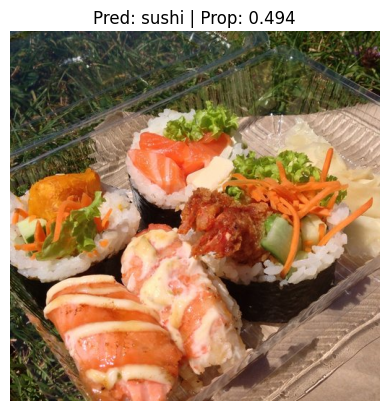

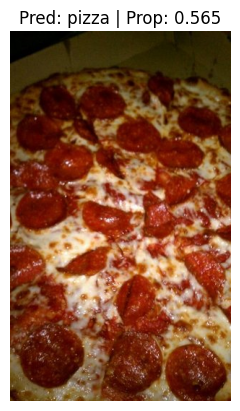

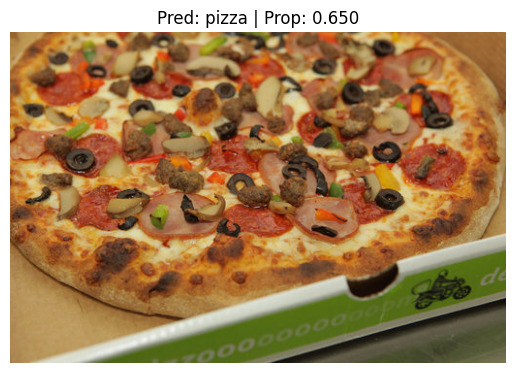

In [23]:
import random

num_images_to_plot = 3
test_image_path_list = list( Path( test_dir).glob( "*/*.jpg"))
test_image_path_sample = random.sample( population=test_image_path_list,
									    k=num_images_to_plot)

for image_path in test_image_path_sample:
	pred_and_plot_image( model, image_path, class_names)